In [1]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


In [14]:
"""
1. 数据获取
使用系统内部的服装数据集构建神经网络。首先导入需要的库文件，x和y中保存训练集的图像和目标。x_test和y_test中保存测试集需要的图像和目标。
(x, y)及(x_test, y_test)都是数组类型。
"""
# keras层方式做前向传播，服装图片分类每一张图片28*28
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics
# 导入数据集管理库，层级，优化器，全连接层容器，测试度量器
import os  # 设置一下输出框打印的内容
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '2'输出栏只打印error信息，其他乱七八糟的信息不打印
 
#（1）导入数据集，数组类型
(x,y),(x_test,y_test) = datasets.fashion_mnist.load_data()
# 查看数据集信息
print(f'x.shape={x.shape}，y.shape={y.shape}') # 查看训练集xy的大小
print(f'x_test.shape={x_test.shape}，y_test.shape={y_test.shape}') #查看测试集的大小

"""
数据集信息如下，变量x中有60k张图片，每张图片的大小是28*28，变量y保存的是每张图片属于哪个分类。
如，y[:5]=[9 0 0 3 0]，第一张图片属于第10个类别，第二张图片属于第0个类别。
"""
print(f'y[:5]={y[:5]}') # 查看y的前5项数据

x.shape=(60000, 28, 28)，y.shape=(60000,)
x_test.shape=(10000, 28, 28)，y_test.shape=(10000,)
y[:5]=[9 0 0 3 0]


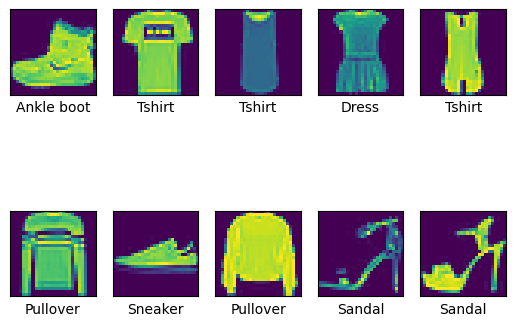

In [15]:
"""
为了我们能对这个数据集有个直观的认识，将图片信息绘制出来，展示前10张图像。
"""
# 数据集展示
import matplotlib.pyplot as plt
import numpy as np
# 每个类别的名称
class_names = ['Tshirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
# 绘制图像
for i in range(0,10):
    plt.subplot(2,5,i+1) # 当前的图绘制在2行5列的第i+1个位置
    plt.imshow(x[i]) 
    plt.xlabel(class_names[y[i]]) #y[i]代表所属分类的标签值
    plt.xticks([])  # 不显示x和y轴坐标
    plt.yticks([])

In [16]:
"""
2. 数据加载
首先对训练集的目标值y进行one-hot编码，便于后续与预测结果计算损失。从标量变成一个向量，索引对应的数值变成1。如编码前y[0]=9，第一张图片对应的分类是第9类，
编码后y[0]=[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]，第9个索引对应的值变成1，其他值都是0。

使用tf.data.Dataset.from_tensor_slices()创建数据集，自动将输入的数组类型转变成tensor类型。使用.map()函数对数据集中的所有元素执行函数内容；
使用.batch()函数指定每次迭代从数据集中取多少个数据，.shuffle()打乱数据集，但不改变xy的对应关系，避免结果出现偶然性。

在对训练集预处理时，不需要对y_test数据进行one-hot编码，因为测试得到的预测结果是一个数值，和y_test比较，看是不是相同就行。
"""
# 数据预处理函数，转变数据类型
def processing(x,y):
    x = tf.cast(x,tf.float32)/255.0  # x数据改变数据类型，并归一化
    y = tf.cast(y,tf.int32)  # 对目标y改变数据类型
    return(x,y)
 
#（2）数据加载
# 对训练集预处理
y = tf.one_hot(y,depth=10)  # one-hot编码，转换成长度为10的向量，对应索引的值变为1
ds_train = tf.data.Dataset.from_tensor_slices((x,y)) # 自动将x和y转换为tensor类型
ds_train = ds_train.map(processing).batch(128).shuffle(10000) # 设置每次采样大小，并打乱
# 对测试集预处理
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
ds_test = ds_test.map(processing).batch(128) #一次测试完所有测试集样本呢，不需要打乱
 
# 生成迭代器，检测数据加载是否正确
sample = next(iter(ds_train)) # 运行一次取出一个batch，即128个数据
print('x_batch:',sample[0].shape,'y_batch:',sample[1].shape) # 查看一次取了多少个

x_batch: (128, 28, 28) y_batch: (128, 10)


In [19]:
"""
3. 构建网络
使用堆层的方法构建全连接层 tf.keras.Sequential()，使用 tf.keras.layers.Dense()添加每一层，构建5层的全连接层，指定激活函数为relu函数，
使网络的维度从[b,28*28]变换到最终的[b,10]，即输出10个分类的结果。使用model.build()函数指定输入层的输入特征大小，model.summary()查看整个网络的结构，
指定优化器跟新权重和偏置optimizers.Adam()，学习率为0.001，即梯度下降速度。
"""
#（3）构建网络
# ==1== 设置全连接层
# [b,784]=>[b,256]=>[b,128]=>[b,64]=>[b,32]=>[b,10]，中间层一般从大到小降维
model = Sequential([
    layers.Dense(256, activation=tf.nn.relu), #第一个连接层，输出256个特征
    layers.Dense(128, activation=tf.nn.relu), #第二个连接层
    layers.Dense(64, activation=tf.nn.relu), #第三个连接层
    layers.Dense(32, activation=tf.nn.relu), #第四个连接层
    layers.Dense(10), #最后一层不需要激活函数，输出10个分类
    ])
 
# ==2== 设置输入层维度
model.build(input_shape=[None, 28*28])
# ==3== 查看网络结构
model.summary()
# ==4== 优化器
# 完成权重更新 w = w - lr * grad
# 网络结构如下，param代表每一层的参数个数，以最后一层为例，权重w的shape为[32,10]，偏置b的shape为[10]，参数个数为32*10+10=330
optimizer = optimizers.legacy.Adam(learning_rate=1e-3) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               200960    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 10)                330       
                                                                 
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________


In [23]:
"""
4. 网络训练
设置整个网络循环20次。for step,(x,y) in enumerate(ds_train)代表每次从训练集中取batch个样本用于训练，等把样本都取完了就完成一次循环。
每次取出的x的shape为[128, 28, 28]，y的shape为[128, 10]。

使用model(x)会自动对输入的x完成权重和偏置计算，得到隐含层最后一层的输出结果logits。接下来计算损失函数，使用交叉熵更新权重偏置。
梯度计算tape.gradient()，以loss2为因变量，权重和偏置为自变量计算梯度，model.trainable_variables()获取网络所有的权重和偏置。

zip(grads, model.trainable_variables) 将梯度和权重及偏置结合在一起。optimizer.apply_gradients()，使用优化器更新梯度，
相当于计算w1 = w1 - lr * grads[0]，并原地更新权重偏置不改变数据类型，简化了w1.assign_sub(lr * grads[0])，不需要一个一个手敲计算更新梯度。
"""
#（5）前向传播
for epoch in range(20): # 运行20次
    # 运行每一个batch
    for step,(x,y) in enumerate(ds_train):
        # ds_train中x的shape是[b,28,28]，由于输入层是[b,28*28]，需要类型转换
        x = tf.reshape(x, [-1, 28*28]) #-1会自动结算第0维
        # 梯度计算
        with tf.GradientTape() as tape:
            # 网络自动运行：[b,784]=>[b,10]
            logits = model(x) #得到最后一层的输出
            # 计算均方误差，真实值y(onehot编码后的)和输出结果之间
            loss1 = tf.reduce_mean(tf.losses.MSE(y, logits)) 
            # 计算交叉熵损失，真实值y(onehot编码后的)和输出概率(logits会自动进行softmax变成概率值)
            loss2 = tf.reduce_mean(tf.losses.categorical_crossentropy(y, logits, from_logits=True))
            
        # 梯度计算，第1个因变量，第2个自变量，model.trainable_variables获得所有的权重和偏置参数
        grads = tape.gradient(loss2, model.trainable_variables) 
        # 更新权重，zip将grads的元素和model.trainable_variables中的元素结合在一起
        optimizer.apply_gradients(zip(grads, model.trainable_variables)) # 完成任务：w1.assign_sub(lr * grads[0])
         
        # 每次运行完一个batch后打印结果
        # if step % 100 == 0:
        #     print(f'epochs:{epoch}, step:{step}, loss_MSE:{loss1}, loss_CE:{loss2}')
    # 一次循环完成的结果
    print(f'epochs:{epoch}, step:{step}, loss_MSE:{loss1}, loss_CE:{loss2}')
    

# 5. 网络测试
# 网络测试是在20次的大循环内部的，使用总预测对了的个数除以总测试样本数来计算模型准确率。同样，每次迭代从测试集中取batch个样本，放入网络计算，得到输出层的结果logits，
# 需要求预测结果概率最大值所在下标，知道了下标索引也就知道了每个测试样本属于第几个分类。
# 使用tf.nn.softmax()函数将输出结果映射到0-1之间，且概率和为1，再配合tf.argmax()就知道概率最大值所在的下标值。将预测值predict和真实值y比较，
# 看是否相同，若相同就是预测对了。tf.equal()返回布尔类型，如果两个变量对应位置的值相同就返回True，再将布尔类型转换位数值类型即可求和tf.reduce_sum()。
#（6）网络测试--前向传播
    total_correct = 0 # 总预测对了的个数
    total_sum = 0 # 总统计的个数
 
    for (x,y) in ds_test: #返回测试集的x和y
        
        # 将x的shape从[b,28,28]=>[b,28*28]
        x = tf.reshape(x, [-1,28*28]) 
        # 计算输出层[b,10]
        logits = model(x)
        # 计算概率最大的值所在的索引        
        # 将logits转换为probility
        prob = tf.nn.softmax(logits, axis=1) # 在最后一个维度上转换概率，且概率和为1
        predict = tf.argmax(prob, axis=1) # 找到最大值所在位置，得到一个标量
        
        # y 是int32类型，shape为[128]
        # predict 是int64类型，shape为[128]
        predict = tf.cast(predict, dtype=tf.int32)
 
        # y是一个向量，每个元素代表属于第几类；predict也是一个向量，下标值指示属于第几类
        # 只要看两个变量的值是否相同
        correct = tf.equal(y, predict) #返回True和False
        # True和False变成1和0，统计1的个数，一共有多少个预测对了
        correct = tf.reduce_sum(tf.cast(correct, dtype=tf.int32))
        
        # 预测对了的个数，correct是tensor类型，变量numpy类型
        total_correct += int(correct) 
        total_sum += x.shape[0] #第0维度，每次测试有多少张图片 
    
    # 计算一次大循环之后的模型准确率
    acc = total_correct/total_sum
    print(f'acc: {acc}')

epochs:0, step:468, loss_MSE:150.45945739746094, loss_CE:0.1653810441493988
acc: 0.8901
epochs:1, step:468, loss_MSE:151.65817260742188, loss_CE:0.08283127099275589
acc: 0.8918
epochs:2, step:468, loss_MSE:154.61395263671875, loss_CE:0.10778392851352692
acc: 0.8881
epochs:3, step:468, loss_MSE:133.02490234375, loss_CE:0.22408217191696167
acc: 0.8914
epochs:4, step:468, loss_MSE:155.21893310546875, loss_CE:0.0942075103521347
acc: 0.889
epochs:5, step:468, loss_MSE:158.70159912109375, loss_CE:0.1310969591140747
acc: 0.8933
epochs:6, step:468, loss_MSE:145.95314025878906, loss_CE:0.15616963803768158
acc: 0.8851
epochs:7, step:468, loss_MSE:249.36277770996094, loss_CE:0.08271139860153198
acc: 0.8917
epochs:8, step:468, loss_MSE:202.84036254882812, loss_CE:0.20656338334083557
acc: 0.8883
epochs:9, step:468, loss_MSE:220.89166259765625, loss_CE:0.1313645839691162
acc: 0.8871
epochs:10, step:468, loss_MSE:215.9788818359375, loss_CE:0.10256929695606232
acc: 0.8839
epochs:11, step:468, loss_MSE